In [8]:
import os
import platform
from wordcloud import WordCloud
from collections import Counter
from kiwipiepy import Kiwi
import matplotlib.pyplot as plt
import pandas as pd
import re
import matplotlib.font_manager as fm

# 한글 폰트 설정
font_path = 'C:/Windows/Fonts/malgun.ttf'  # 맑은 고딕 폰트 경로
fontprop = fm.FontProperties(fname=font_path)
plt.rc('font', family='Malgun Gothic')

# 텍스트 파일 불러오기(파일명만 변경)
text_file_path = 'data/q14_1.txt'
with open(text_file_path, 'r', encoding='utf-8') as file:
    text = file.read()

# 텍스트 정제 함수
def text_clean(text):
    pattern = '([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)' # E-mail제거
    text = re.sub(pattern, '', text)
    pattern = '(http|ftp|https)://(?:[-\w.]|(?:%[\da-fA-F]{2}))+' # URL제거
    text = re.sub(pattern, '', text)
    pattern = '([ㄱ-ㅎㅏ-ㅣ]+)'  # 한글 자음, 모음 제거    
    text = re.sub(pattern, '', text)
    pattern = '([a-zA-Z0-9]+)'   # 알파벳, 숫자 제거  
    text = re.sub(pattern, '', text)
    pattern = '<[^>]*>'         # HTML 태그 제거
    text = re.sub(pattern, '', text)
    pattern = '[^\w\s]'         # 특수기호제거
    text = re.sub(pattern, '', text)
    return text  

text = text_clean(text)

# 형태소 분석기 객체 생성
kiwi = Kiwi()

# 사용자 사전 추가 (sample)
kiwi.add_user_word('맛점', 'NNP', 0)

# 형태소 분석 및 태깅
tagged = kiwi.analyze(text)[0][0]

# 불용어 불러오기
stopwords_path = 'db/Korean Stopwords.txt'
with open(stopwords_path, 'r', encoding='utf-8') as file:
    stopwords = set(file.read().splitlines())

# 추가 불용어 리스트
stopwords_n = { '없음', '울진', '기억안남', '울진군', '그냥', '이유', '기억', '방문', '모름', '없어요'}
stopwords.update(stopwords_n)

def clear_console():
    """
    콘솔 출력을 지우는 대신 여러 줄의 빈 줄을 출력하여 이전 출력을 덮어씁니다.
    """
    print("\n" * 100)  # 100줄의 빈 줄을 출력하여 콘솔 내용을 덮어씀

def print_top_nouns(nouns_df, top_n=20):
    """
    명사와 빈도수를 데이터프레임에서 상위 top_n개 출력합니다.
    """
    clear_console()
    top_n_df = nouns_df.head(top_n)  # 상위 top_n개의 항목을 선택
    print(f"\n현재 분석된 명사와 빈도수 상위 {top_n}개:")
    print(top_n_df.to_string(index=False))  # 인덱스 없이 출력

def get_additional_stopwords():
    """
    사용자로부터 추가 불용어를 입력받고, 집합으로 반환합니다.
    """
    user_input = input("워드클라우드에서 제외할 키워드를 입력하세요 (쉼표로 구분): ")
    return set(map(str.strip, user_input.split(',')))

def filter_nouns_with_stopwords(tagged, stopwords):
    """
    현재의 불용어 리스트를 기반으로 명사와 고유명사만 필터링합니다.
    """
    return [(word, tag) for word, tag, *_ in tagged if tag in ('NNG', 'NNP') and word not in stopwords and len(word) > 1]

def generate_wordcloud(nouns_with_tags, output_dir):
    """
    주어진 명사 리스트를 바탕으로 워드클라우드를 생성하고 저장합니다.
    """
    # 명사와 태그를 결합한 빈도수 계산
    nouns_counter = Counter([word for word, tag in nouns_with_tags])

    # 상위 50개의 명사 추출 및 빈도수 바탕 딕셔너리 생성
    most_common_nouns = nouns_counter.most_common(50)
    nouns_dict = dict(most_common_nouns)

    # 워드클라우드 생성 (픽셀 크기 설정, margin=20으로 빈 공간 작게)
    wordcloud = WordCloud(
        font_path=font_path,
        background_color='white',
        width=800,  # 가로 8cm에 해당하는 픽셀 수
        height=800,   # 세로 8cm에 해당하는 픽셀 수
        margin=20     # 워드클라우드 외곽의 여백을 20
    ).generate_from_frequencies(nouns_dict)

    # 가로 8cm, 세로 8cm 크기로 설정 (인치로 변환)
    plt.figure(figsize=(3.15, 3.15))  #  8cm = 3.15인치
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')

    # 그림을 8cm x 8cm 크기로 저장, 빈 공간 제거
    plt.savefig(
        f'{output_dir}/wordcloud(800X800).png',
        dpi=254,
        bbox_inches='tight',  # 여백을 최소화
        pad_inches=0          # 추가 패딩을 없앰
    )
    plt.show()

# 분석 프로세스 시작
while True:
    # 현재의 불용어 리스트를 기반으로 필터링
    nouns_with_tags = filter_nouns_with_stopwords(tagged, stopwords)

    # 명사와 태그를 결합한 빈도수 계산 및 데이터프레임 생성
    nouns_counter = Counter(nouns_with_tags)
    nouns_data = [(word, tag, count) for (word, tag), count in nouns_counter.most_common()]
    nouns_df = pd.DataFrame(nouns_data, columns=['Noun', 'Tag', 'Frequency']).sort_values(by='Frequency', ascending=False)

    # 명사와 빈도수 상위 20개 출력
    print_top_nouns(nouns_df)

    # 추가 불용어 입력
    user_stopwords = get_additional_stopwords()
    if "끝" in user_stopwords:
        print("불용어 입력을 종료합니다.")
        break
    stopwords.update(user_stopwords)









































































































현재 분석된 명사와 빈도수 상위 20개:
Noun Tag  Frequency
  필요 NNG         96
  시설 NNG         86
  보수 NNG         83
 화장실 NNG         76
  누수 NNG         60
  공사 NNG         59
  사용 NNG         56
  불편 NNG         56
  하자 NNG         53
  건물 NNG         51
  발생 NNG         48
  설계 NNG         44
  설치 NNG         43
  공간 NNG         41
  내부 NNG         39
  문제 NNG         39
  개선 NNG         38
  만족 NNG         37
  부족 NNG         35
  바닥 NNG         33






































































































현재 분석된 명사와 빈도수 상위 20개:
Noun Tag  Frequency
  필요 NNG         96
  시설 NNG         86
  보수 NNG         83
 화장실 NNG         76
  누수 NNG         60
  공사 NNG         59
  사용 NNG         56
  불편 NNG         56
  하자 NNG         53
  건물 NNG         51
  발생 NNG         48
  설계 NNG         44
  설치 NNG         43
  공간 NNG         41
  문제 NNG         39
  내부 NNG  

In [ ]:
# 최종 필터링 결과로 워드클라우드 생성
print("최종 워드클라우드를 생성합니다...")
file_name = os.path.basename(text_file_path).split('.')[0]
output_dir = f'data/{file_name}'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

generate_wordcloud(nouns_with_tags, output_dir)

In [ ]:
# 최종 필터링 결과로 워드클라우드 생성
print("최종 워드클라우드를 생성합니다...")
file_name = os.path.basename(text_file_path).split('.')[0]
output_dir = f'data/{file_name}'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

generate_wordcloud(nouns_with_tags, output_dir)

# 라이브러리 불러오기

In [53]:
import os
from wordcloud import WordCloud
from collections import Counter
from kiwipiepy import Kiwi
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict

# 한글 폰트 설정

In [54]:
import matplotlib.font_manager as fm
font_path = 'C:/Windows/Fonts/malgun.ttf'  # 맑은 고딕 폰트 경로
fontprop = fm.FontProperties(fname=font_path)
plt.rc('font', family='Malgun Gothic')


# 텍스트 파일 불러오기(파일명만 변경)

In [60]:
text_file_path = 'data/C_99.txt'
with open(text_file_path, 'r', encoding='utf-8') as file:
    text = file.read()

# 텍스트 정제

In [61]:
import re

def text_clean(text):
    pattern = '([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)' # E-mail제거
    text = re.sub(pattern, '', text)
    pattern = '(http|ftp|https)://(?:[-\w.]|(?:%[\da-fA-F]{2}))+' # URL제거
    text = re.sub(pattern, '', text)
    pattern = '([ㄱ-ㅎㅏ-ㅣ]+)'  # 한글 자음, 모음 제거    
    text = re.sub(pattern, '', text)
    pattern = '([a-zA-Z0-9]+)'   # 알파벳, 숫자 제거  
    text = re.sub(pattern, '', text)
    pattern = '<[^>]*>'         # HTML 태그 제거
    text = re.sub(pattern, '', text)
    pattern = '[^\w\s]'         # 특수기호제거
    text = re.sub(pattern, '', text)
    return text  

text = text_clean(text)


# 형태소 분석기 객체 생성


In [62]:
kiwi = Kiwi()

# 사용자 사전 추가

In [63]:
kiwi.add_user_word('맛점', 'NNP', 0)

True

# 형태소 분석 및 태깅

In [64]:
tagged = kiwi.analyze(text)[0][0]

# 형태소 태깅 결과 출력
print("형태소 태깅 결과:")
for word, tag, *_ in tagged:
    print(f"{word}: {tag}")



형태소 태깅 결과:
여군: NNG
의: JKG
비율: NNG
이: JKS
점차: MAG
높: VA
어: EC
지: VX
ᆷ: ETN
에: JKB
따르: VV
어: EC
여군: NNG
필수: NNG
시설: NNG
의: JKG
공간: NNG
확장: NNG
필요: NNG
현재: MAG
대변: NNG
기: XSN
대: NNG
샤워실: NNG
휴게: NNG
공간: NNG
이: JKS
너무: MAG
좁: VA-R
음: EF
군: NNG
특성: NNG
상: XSN
건물: NNG
을: JKO
상당: NNG
기간: NNG
오래: MAG
사용: NNG
하: XSV
어야: EC
하: VX
는데: EC
방수: NNG
배수: NNG
부분: NNG
이: JKS
매우: MAG
미흡: NNG
하: XSA
ᆷ: EC
유지: NNG
보수: NNG
이후: NNG
언제: MAG
또: MAG
빗물: NNG
이: JKS
새: VV
ᆯ지: EC
모르: VV
는다는: ETM
불안감: NNG
증대: NNG
유지: NNG
보수: NNG
기간: NNG
을: JKO
명시: NNG
하: XSV
지: EC
말: VX
고: EC
사용자: NNG
요구: NNG
시공사: NNG
시설: NNG
설계: NNG
문제: NNG
등: NNB
이: VCP
ᆯ: ETM
경우: NNG
에: JKB
는: JX
장기간: NNG
유지: NNG
보수: NNG
가: JKS
가능: NNG
하: XSA
었: EP
으면: EC
좋: VA
겠: EP
음: EF
지나: VV
ᆫ: ETM
폭우: NNG
시: NNB
베란다: NNG
가스: NNG
실: NNG
의: JKG
천정: NNG
일부: NNG
가: JKS
떨어지: VV
었: EP
습니다: EF
보수: NNG
부탁: NNG
드리: VV
ᆸ니다: EF
매일: MAG
환기: NNG
하: XSV
ᆷ: ETN
에: JKB
도: JX
주방: NNG
과: JC
작: VA
은: ETM
방: NNG
에: JKB
곰팡이: NNG
가: JKS
자주: MAG
발생: NNG
하: XSV
ᆸ니다: EC
원인: NNG
과:

# 불용어 불러오기

In [65]:
stopwords_path = 'db/Korean Stopwords.txt'
with open(stopwords_path, 'r', encoding='utf-8') as file:
    stopwords = set(file.read().splitlines())

# 불용어 추가 처리 단어 검토

In [66]:
nounsx = [word for word, tag, *_ in tagged if tag in ('NNG', 'NNP') ]

In [67]:
# 2글자 단어 
nouns_l2 = [n for n in nounsx if len(n)==2]
nouns_l2_counter = Counter(nouns_l2)
print("\n2글자 명사 빈도수 (내림차순):")
for noun, freq in nouns_l2_counter.most_common():
    print(f" '{noun}' : {freq}")




2글자 명사 빈도수 (내림차순):
 '필요' : 96
 '시설' : 86
 '보수' : 83
 '공사' : 61
 '누수' : 60
 '사용' : 56
 '불편' : 56
 '하자' : 53
 '건물' : 51
 '발생' : 48
 '설계' : 44
 '설치' : 43
 '공간' : 41
 '문제' : 39
 '내부' : 39
 '개선' : 38
 '만족' : 37
 '부족' : 35
 '바닥' : 33
 '배수' : 32
 '부분' : 32
 '조치' : 30
 '천장' : 29
 '처리' : 28
 '방음' : 28
 '현상' : 25
 '업체' : 24
 '부대' : 22
 '생각' : 22
 '기간' : 20
 '사항' : 20
 '반영' : 20
 '보완' : 20
 '준공' : 19
 '전기' : 19
 '외부' : 19
 '포상' : 19
 '마감' : 18
 '추가' : 17
 '청소' : 17
 '신축' : 17
 '관련' : 17
 '환기' : 16
 '정비' : 16
 '수압' : 16
 '유지' : 15
 '경우' : 15
 '우천' : 15
 '악취' : 15
 '인원' : 15
 '이용' : 14
 '관리' : 14
 '고장' : 13
 '감사' : 13
 '고려' : 13
 '수리' : 13
 '창고' : 13
 '변기' : 13
 '방수' : 12
 '이후' : 12
 '가능' : 12
 '온도' : 12
 '벽면' : 12
 '이동' : 12
 '요망' : 12
 '창문' : 12
 '숙소' : 12
 '장비' : 12
 '식당' : 12
 '사격' : 12
 '미흡' : 11
 '불량' : 11
 '작동' : 11
 '상태' : 11
 '편의' : 11
 '시간' : 10
 '냄새' : 10
 '계단' : 10
 '간부' : 10
 '크기' : 10
 '지속' : 10
 '소리' : 10
 '요청' : 10
 '느낌' : 10
 '균열' : 10
 '규모' : 10
 '예산' : 10
 '천정' : 9
 '위치' : 9
 '차

In [68]:
# 3글자 단어 
nouns_l3 = [n for n in nounsx if len(n)==3]
nouns_l3_counter = Counter(nouns_l3)
print("\n3글자 명사 빈도수 (내림차순):")
for noun, freq in nouns_l3_counter.most_common():
    print(f" '{noun}' : {freq}")



3글자 명사 빈도수 (내림차순):
 '화장실' : 76
 '곰팡이' : 23
 '배수로' : 21
 '에어컨' : 21
 '환풍기' : 18
 '시설물' : 16
 '사무실' : 16
 '사용자' : 14
 '세탁기' : 14
 '생활관' : 14
 '건조기' : 13
 '샤워실' : 12
 '출입문' : 11
 '콘센트' : 10
 '샤워장' : 9
 '격납고' : 8
 '샤워기' : 8
 '인터넷' : 8
 '어려움' : 7
 '세면대' : 7
 '훈련장' : 7
 '체단실' : 7
 '시스템' : 6
 '배수구' : 6
 '페인트' : 6
 '아쉬움' : 5
 '장마철' : 5
 '휴게실' : 5
 '시공사' : 4
 '베란다' : 4
 '통신사' : 4
 '시멘트' : 4
 '마감재' : 4
 '오작동' : 4
 '주차장' : 4
 '보일러' : 4
 '쓰레기' : 4
 '데이터' : 4
 '핸드폰' : 4
 '세탁실' : 4
 '헬스장' : 4
 '장기간' : 3
 '기계실' : 3
 '이용자' : 3
 '스위치' : 3
 '경보기' : 3
 '마무리' : 3
 '작업장' : 3
 '보급품' : 3
 '배수관' : 3
 '중계기' : 3
 '메뉴얼' : 3
 '실리콘' : 3
 '지상파' : 2
 '케이블' : 2
 '현관문' : 2
 '통제실' : 2
 '소모품' : 2
 '미끄럼' : 2
 '스프링' : 2
 '오른쪽' : 2
 '연병장' : 2
 '감독관' : 2
 '뒷정리' : 2
 '전기선' : 2
 '탈의실' : 2
 '고시원' : 2
 '수처리' : 2
 '건조대' : 2
 '손잡이' : 2
 '회의실' : 2
 '항공기' : 2
 '컴퓨터' : 2
 '완성도' : 2
 '인원수' : 2
 '소변기' : 2
 '문제점' : 2
 '가성비' : 2
 '휴대폰' : 2
 '장애인' : 2
 '하수구' : 2
 '칸막이' : 2
 '세면장' : 2
 '취사장' : 2
 '정수기' : 2
 '사이즈' : 2
 '태양광' : 2
 '물받이' : 

# 추가 불용어 리스트


In [69]:
stopwords_n = { '없음', '울진', '기억안남', '울진군', '그냥', '이유', '기억', '방문', '모름', '없어요'
}

# 불용어 리스트 합치기

In [70]:
stopwords.update(stopwords_n)

# 불용어 필터링 후 일반명사(NNG), 고유명사(NNP) 추출

In [71]:
nouns_with_tags = [(word, tag) for word, tag, *_ in tagged if tag in ('NNG', 'NNP') and word not in stopwords and len(word) > 1]

#품사표 참조 (https://docs.komoran.kr/firststep/postypes.html)

# 새로운 폴더 생성

In [72]:
file_name = os.path.basename(text_file_path).split('.')[0]
output_dir = f'data/{file_name}'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 결과물 저장 및 TOP10 시각화

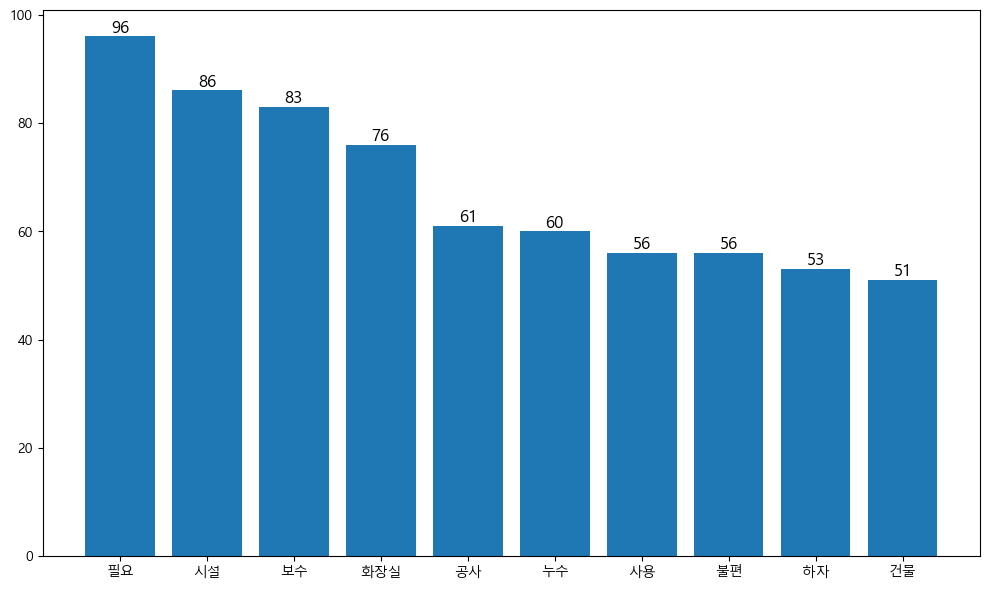

In [74]:
# 명사와 태그를 결합한 빈도수 계산
nouns_counter = Counter([word for word, tag in nouns_with_tags])
nouns_summary = defaultdict(lambda: {'Tag': set(), 'Frequency': 0})



for word, tag in nouns_with_tags:
    nouns_summary[word]['Tag'].add(tag)
    nouns_summary[word]['Frequency'] = max(nouns_summary[word]['Frequency'], nouns_counter[word])

# 명사와 병합된 태그, 빈도수를 데이터프레임으로 생성
nouns_data = [(word, ','.join(sorted(tags)), info['Frequency']) for word, info in nouns_summary.items() for tags in [info['Tag']]]

nouns_df = pd.DataFrame(nouns_data, columns=['Noun', 'Tag', 'Frequency']).sort_values(by='Frequency', ascending=False)

# 정렬된 데이터프레임을 엑셀 파일로 저장
nouns_df.to_excel(f'{output_dir}/nouns_frequency.xlsx', index=False)

# 상위 10개의 명사 빈도수를 시각화하여 그림 파일로 저장
most_common_nouns_Top10 = nouns_counter.most_common(10)
labels, counts = zip(*most_common_nouns_Top10)
plt.figure(figsize=(10, 6))
bars = plt.bar(labels, counts)
# 가로변수명 plt.xlabel('Nouns')
# 세로변수명 plt.ylabel('Frequency')
# 제목 plt.title('Top 10 Noun Frequencies')


# 그래프에 빈도수 표시
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, int(yval), ha='center', va='bottom', fontsize=12, color='black')
plt.tight_layout()
plt.savefig(f'{output_dir}/top10_nouns_barplot.png')  # 그림 파일로 저장
plt.show()






# 상위 50개의 명사 추출 및 빈도수 바탕 딕셔너리 생성

In [75]:
most_common_nouns = nouns_counter.most_common(50)
nouns_dict = dict(most_common_nouns)

# 워드클라우드 시각화 1


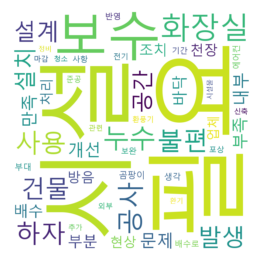

In [76]:
# 워드클라우드 생성 (픽셀 크기 설정, margin=20으로 빈 공간 작게)
wordcloud = WordCloud(
    font_path=font_path,
    background_color='white',
    width=800,  # 가로 8cm에 해당하는 픽셀 수
    height=800,   # 세로 8cm에 해당하는 픽셀 수
    margin=20     # 워드클라우드 외곽의 여백을 20
).generate_from_frequencies(nouns_dict)

# 가로 8cm, 세로 8cm 크기로 설정 (인치로 변환)
plt.figure(figsize=(3.15, 3.15))  #  8cm = 3.15인치
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

# 그림을 8cm x 8cm 크기로 저장, 빈 공간 제거
plt.savefig(
    f'{output_dir}/wordcloud(800X800).png',
    dpi=254,
    bbox_inches='tight',  # 여백을 최소화
    pad_inches=0          # 추가 패딩을 없앰
)
plt.show()


# 워드클라우드 시각화 2

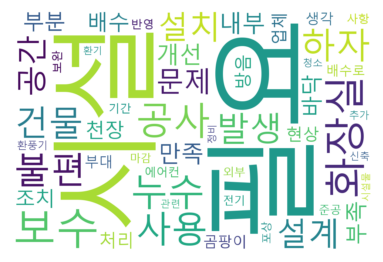

In [77]:
# 워드클라우드 생성 (픽셀 크기 설정, margin=20으로 빈 공간 작게)
wordcloud = WordCloud(
    font_path=font_path,
    background_color='white',
    width=1200,  # 가로 12cm에 해당하는 픽셀 수
    height=800,   # 세로 8cm에 해당하는 픽셀 수
    margin=20     # 워드클라우드 외곽의 여백을 20
).generate_from_frequencies(nouns_dict)

# 가로 12cm, 세로 8cm 크기로 설정 (인치로 변환)
plt.figure(figsize=(4.72, 3.15))  # 12cm = 4.72인치, 8cm = 3.15인치
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

# 그림을 12cm x 8cm 크기로 저장, 빈 공간 제거
plt.savefig(
    f'{output_dir}/wordcloud(1200X800).png',
    dpi=254,
    bbox_inches='tight',  # 여백을 최소화
    pad_inches=0          # 추가 패딩을 없앰
)
plt.show()
